In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 155203 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.27-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.27-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=None&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force


KeyboardInterrupt: ignored

In [ ]:
!pip install numba

In [ ]:
import numba as nb
import numpy as np
spec = [
    ('c', nb.types.int64),    
    ('m', nb.types.float64), 
    ('nParams', nb.types.float64), 
    ('eps', nb.types.float64), 
    ('maxIter', nb.types.int64),
    ('data', nb.types.float64[:]),
]
@nb.experimental.jitclass(spec)
class ChairaIFCM:

    def __init__(self, c, m, nParams, eps, maxIter, data):
        self.c = c
        self.m = m
        self.nParams=nParams
        self.eps = eps
        self.maxIter = maxIter
        self.data = data

    def InitialMembership_Creation(self):
      U = np.random.randint(100, 200, size=(len(self.data), self.c)).astype(np.float64)
      for i in range(U.shape[0]):
        temp_U=U[i]/np.sum(U[i])
        for j in range(U.shape[1]):
          U[i][j]=temp_U[j]
      return U

    def V(self, U):
      V_array=[]
      U_m=U**self.m
      for j in range(U.shape[1]):
        temp_V_pay=0
        temp_V_payda=0
        for i in range(U.shape[0]):
          temp_V_pay+=U_m[i,j]*self.data[i]
          temp_V_payda+=U_m[i,j]
        V_array.append(temp_V_pay/temp_V_payda)
      return np.asarray(V_array).astype(np.float64)

    def V_s(self, U_s):
      V_s_array=[]
      for i in range(U_s.shape[1]):
        temp_V_pay=0
        temp_V_payda=0
        for k in range(U_s.shape[0]):
          temp_V_pay+=U_s[i,k]*self.data[k]
          temp_V_payda+=U_s[i,k]
        V_s_array.append(temp_V_pay/temp_V_payda)
      return np.asarray(V_s_array).astype(np.float64)
        
    def U(self, V_old):
        U_new = np.zeros(shape=(len(self.data), self.c))
        for i in range(U_new.shape[0]):
            for j in range(U_new.shape[1]): 
                p1=self.Dist2(self.data[i], V_old[j])
                result=0
                for k in range(self.c):
                    p2=self.Dist2(self.data[i], V_old[k])
                    result+=(p1/p2)**(1/((self.m)-1))
                U_new[i,j]=1/result
        return np.asarray(U_new).astype(np.float64)
      
    def U_s(self, U):
        U_s_matrix = np.zeros(shape=(len(self.data), self.c))
        for i in range(U.shape[0]):
            for k in range(U.shape[1]):
                U_s_matrix[i][k] = 1-self.Yager_Negation(U[i,k])
        
        return U_s_matrix
    
    def Sugeno_Negation(self, Uik):
        return (1-Uik)/(1+self.nParams*Uik)

    def Yager_Negation(self, Uik):
        return (1-Uik**self.nParams)**(1/self.nParams)

    def Pi(self, U):
        Pi_matrix = np.zeros(shape=(len(self.data), self.c))
        for i in range(U.shape[0]):
            for k in range(U.shape[1]):
                Pi_matrix[i][k] = 1-U[i,k]-self.Yager_Negation(U[i,k])
        
        return np.asarray(Pi_matrix)

    def Pi_s(self, Pi):
        Pi_s_matrix = []
        for i in range(Pi.shape[1]):
          r_sum=0
          for k in range(Pi.shape[0]):
            r_sum += Pi[k,i]
          Pi_s_matrix[i]=(1/Pi.shape[0])*r_sum
        
        return np.asarray(Pi_s_matrix)

    def J2(self, Pi_s):
      r_sum=0
      for i in range(self.c):
        r_sum+=Pi_s[i]*np.exp(1-Pi_s[i])
      return r_sum

    def J1(self, U, V):
        """
        Objective Function (Amaç Fonksiyonu)
        """
        U_m = U**self.m
        result = 0
        for j in range(self.c):
            for i in range(self.data.shape[0]):
                result += U_m[i][j] * self.Dist2(self.data[i], V[j])**2
        return result

    def J(self, U, V, Pi_s):
        return self.J1(U,V) + self.J2(Pi_s)

    def Dist(self, X, Y):
        result=0
        for i in range(len(X)):
          result+=(X[i]-Y[i])**2
        return result**1/2

    def Dist2(self, X, Y):
        result=(X-Y)**2
        return result**1/2
  
    def Cluster(self):
        U = self.InitialMembership_Creation()
        U_s = self.U_s(U)
        V =  np.random.randint(low=-4, high=4, size=(self.c,)).astype(np.float64)
        print("INFO: The initial membership matrix has been created.")
        iteration = 1
        loss_values = []
        print("INFO: Please wait, clusters are segmented...")
        while iteration <= self.maxIter:
            u_s_old=U_s
            V = self.V(U)
            U = self.U(V)
            U_s=self.U_s(U)
            u_s_new=U_s
            loss = np.linalg.norm(u_s_old - u_s_new)
            loss_values.append(loss)
            if loss < self.eps:
                break
            iteration += 1
        V=self.V_s(U_s)
        print("INFO: Clustering Complete !")
        return U_s,V,loss_values

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("drive/MyDrive/Colab Notebooks")

Mounted at /content/drive


INFO: The initial membership matrix has been created.
INFO: Please wait, clusters are segmented...
INFO: Clustering Complete !
0.21807393630345662


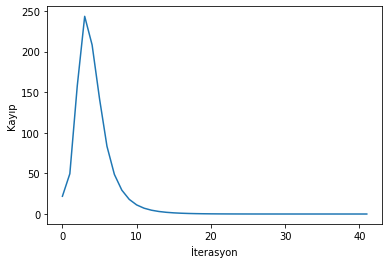

[0.09556501212712731, 0.21514341469445006, 0.16021797773446336]


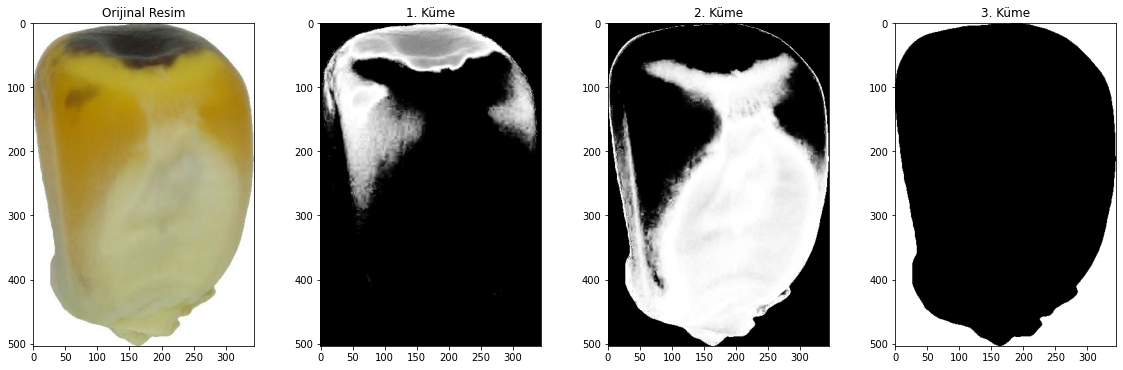

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import *
from statistics import variance
%matplotlib inline
import time
img_orijinal=cv2.imread("h4.jpg")
img_orijinal=img=cv2.cvtColor(img_orijinal, cv2.COLOR_BGR2RGB)
img_gray=img=cv2.cvtColor(img_orijinal, cv2.COLOR_RGB2GRAY)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(img_gray)
data=normalized_data.flatten()
img_shape=img.shape
m=1.3
a=3
data=img_gray.flatten()
x=data.astype(float)
fuzz=ChairaIFCM(3, m, a, 10e-5, 50, x)
basz=time.time()
U, V, loss=fuzz.Cluster()
bitz=time.time()
sonuc=bitz-basz
print(sonuc/60)
plt.plot(loss[:])
plt.xlabel("İterasyon")
plt.ylabel("Kayıp")
plt.show()
len(loss)

plt.figure(figsize=(40,40))
satir=2
sutun=8
plt.subplot(satir,sutun,1)   
plt.imshow(img_orijinal, cmap=cm.gray)
plt.title("Orijinal Resim")
variances=[]
for i in range(0,fuzz.c):
  plt.subplot(satir,sutun,i+2)
  u_i=np.reshape(U[:,i],img_shape)
  variances.append(variance(U[:,i]))   
  plt.imshow(u_i, cmap=cm.gray)
  plt.title(str(i+1)+". Küme")
finalKumeNo=np.argmax(variances)
print(variances)
plt.subplots_adjust(hspace=0.2, wspace=0.3)
plt.show()

In [ ]:
from numpy.core.fromnumeric import argmin
import numpy as np

def pc(x, u, v, m):
    c, n = u.shape
    return np.square(u).sum()/n

def mpc(x, u, v, m):
  n, c = u.shape
  return (c/(c - 1))*pc(x, u, v, m) - (1/c-1)

def xb(x, u, v, m):
    numerator = 0.0
    dist=[]
    n,c=u.shape
    for j in range(c):
      for i in range(n):
        numerator += (u[i][j]**2) * (fuzz.Dist2(x[i], v[j])**2)
    
    for i in range(c):
      for j in range(c):
        if i==j: break
        dist.append(np.abs(v[i]-v[j]))
    return numerator/(n*min(dist)**2)

def pe(x,u,v,m):
  with np.errstate(divide='ignore'): # quando u_ik=0 gera erro de divisão.
    log_U = np.log(u)                # quando u_ik=0, log(u_ik)=inf.
  log_U[np.isinf(log_U)] = 1 # qualquer valor, eles serão multiplicados por zero.
  
  n,_ = u.shape
  return -(1/n)*np.sum( np.multiply(u, log_U) )

methods = [pc, mpc, xb]
targets = "max max min".split()


In [ ]:
U.shape

(191619, 3)

In [ ]:
print("PC: ", pc(data, U, V, 1.3))
print("NPC: ", mpc(data, U, V, 1.3))
print("XB: ", xb(data, U, V, 1.3))
print("PE: ", pe(data, U, V, 1.3))


PC:  45360.39905736601
NPC:  68041.26525271569
XB:  919837694.7370523
PE:  0.09479320196815531


INFO: The initial membership matrix has been created.
INFO: Please wait, clusters are segmented...
INFO: Clustering Complete !
INFO: The initial membership matrix has been created.
INFO: Please wait, clusters are segmented...
INFO: Clustering Complete !
INFO: The initial membership matrix has been created.
INFO: Please wait, clusters are segmented...
INFO: Clustering Complete !
INFO: The initial membership matrix has been created.
INFO: Please wait, clusters are segmented...
INFO: Clustering Complete !
INFO: The initial membership matrix has been created.
INFO: Please wait, clusters are segmented...
INFO: Clustering Complete !
INFO: The initial membership matrix has been created.
INFO: Please wait, clusters are segmented...
INFO: Clustering Complete !
INFO: The initial membership matrix has been created.
INFO: Please wait, clusters are segmented...
INFO: Clustering Complete !
INFO: The initial membership matrix has been created.
INFO: Please wait, clusters are segmented...
INFO: Cluste

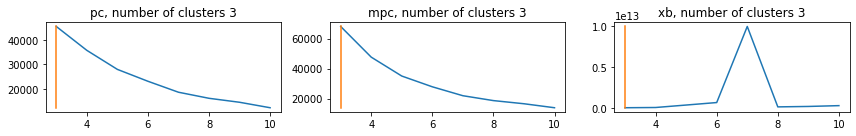

In [ ]:
results = []
cs = np.arange(3, 11)
for c in cs:
  fuzz=ChairaIFCM(c, m, a, 10e-5, 50, x)
  u, v, loss=fuzz.Cluster()
  results.append([])
  for method in methods:
    result = method(x, u, v, m)
    results[-1].append(result)

results = np.array(results)

ny = 1
nx = 3
plt.figure(figsize=(12,2))
# plot cluster validity indices
for i, method in enumerate(methods):
    plt.subplot(ny, nx, 1 + i)
    column = results[:, i]
    plt.plot(cs, column)

    # find best cluster size for cluster validity index
    if targets[i] == "min":
        c = cs[np.argmin(column)]
    else:
        c = cs[np.argmax(column)]
    
    plt.title("%s, number of clusters %d"%(method.__name__, c))
    
    plt.plot([c, c], [np.min(column), np.max(column)])

plt.tight_layout()
plt.savefig("cvi.png", dpi=300)
print(results)

In [ ]:
a

1186182856

In [ ]:
1.18618286e+09

1186182860.0

In [ ]:
a=(1.18618286e+09>1.06514359e+11)

In [ ]:
1.18618286e+09

1186182860.0

In [ ]:
1.06514359e+11

106514359000.0